# **Corner Detection and Feature Matching**

# Introduction

In this homework, you will practise corner detection and feature matching with opencv. In this link, [feature matching](https://drive.google.com/drive/folders/1WYP68d5pKTTZdXxa1mZZuPcY22iaILz2?usp=sharing) , there are 11 pictures I took around campus, one target image, 10 references. Your task is as follows:
1. Find out keypoints in each image using Harris Corner Detection or Shi-Tomasi Detection
2. Build descriptors using SIFT or ORB
3. Match keypoints in two images using Euclidean distance or other metrics
4. Find out the reference image that matches the target best (also based on distance or other metrics)

Hints:

Because the images are high resolution images, corner detection could possibly output tons of points. You need to specify a certain number of corner points you need, for the best performance of your feature matching algorithm. Or you can take your own pictures, one target, and at least 10 references.

Rubric:

Find correct key points with corner detection algo: 40pts

Build descriptors for the key points from corner detection algo: 40 pts

Perform feature matching: 20 pts


In [1]:
# from google.colab.patches import cv2_imshow
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os

images location:
[feature matching](https://drive.google.com/drive/folders/1WYP68d5pKTTZdXxa1mZZuPcY22iaILz2?usp=sharing)

To make this easier, I added two commands below to download the zip file and unzip the images right in the /content folder

In [7]:
!gdown 1LoHRj44aOawe5zRnE13HQ7bt2lQXpDHv
!unzip data.zip

# Corner Detection
Harris Corner Dection document: https://docs.opencv.org/3.4/dc/d0d/tutorial_py_features_harris.html

# Feature Matching
ORB/SIFT/FLANN feature matching document: https://docs.opencv.org/4.x/dc/dc3/tutorial_py_matcher.html

# Output Example

You can try different corner detection and feature matching algorithms. Here's a simple example of Harris Corner Detection and Flann matching output:

Corner Detection:

<img src="https://drive.google.com/uc?export=view&id=1_lxN5962rkummApSF3GyPnEyXZKmc-jA" width=600>


Feature Matching:

<img src="https://drive.google.com/uc?export=view&id=1FoqX3JlU9B7xup19S_-w554bb_MsE28t" width=600>

<img src="https://drive.google.com/uc?export=view&id=1q3cYnMHQFxnVbzxpRMSEy43A7pG69qYm" width=600>


# Create a Feature Extractor Class

In [57]:
class FeatureExtractor:
    def __init__(self, image_path):
        """
        Initialize the FeatureExtractor class
        Args:
            image_path (str): Path to the image
        - Performs Harris corner detection on the image and stores the corner locations
        - Includes a function to display the image with the detected corners
        - Includes a function to perform feature matching with another FeatureExtractor object
        """
        self.image_path = image_path
        self.corners = []
        self.detect_corners()

    def detect_corners(self, block_size=7, ksize=5, k=0.06, threshold=0.01):
        """ 
        Detect corners in the image using Harris corner detection
        """
        # Load the image
        self.image = cv2.imread(self.image_path)
        # Convert the image to grayscale
        gray = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)
        # Perform Harris corner detection
        corner_response = cv2.cornerHarris(gray, blockSize=block_size, ksize=ksize, k=k)
        # Threshold the corner response to identify strong corners
        corners = np.where(corner_response > threshold * corner_response.max())
        # Store the corners for this image
        self.corners = [corners]

    def display_image_with_corners(self):
        """
        Display the image with the detected corners
        """
        # Draw circles at the corner locations
        corners = self.corners[-1]
        radius = int(self.image.shape[1] / 1000)
        for pt in zip(*corners[::-1]):
            cv2.circle(self.image, pt, radius=radius, color=(0, 255, 0), thickness=2)
        # Display the image with detected corners using matplotlib
        plt.imshow(cv2.cvtColor(self.image, cv2.COLOR_BGR2RGB))
        plt.title('Corners')
        plt.axis('off')
        plt.show()

    def match_features(self, other_img, display=False):
        """
        Perform feature matching between the current image and another image
        Args:
            other_img (FeatureExtractor): Another instance of FeatureExtractor representing the other image
            display (bool): Whether to display the matched features
        Returns:
            good_matches (list): List of good matches between the two images
        """
        # Initialize ORB detector
        orb = cv2.ORB_create()
        # Detect keypoints and compute descriptors for the current image
        keypoints_self, descriptors_self = orb.detectAndCompute(self.image, None)
        # Detect keypoints and compute descriptors for the other image
        keypoints_other, descriptors_other = orb.detectAndCompute(other_img.image, None)
        # Create a Brute-Force Matcher
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
        # Match the descriptors
        matches = bf.match(descriptors_self, descriptors_other)
        # Sort the matches by distance
        matches = sorted(matches, key=lambda x: x.distance)
        # Select only the good matches (you can adjust the threshold as needed)
        good_matches = [match for match in matches if match.distance < 50]
        if display:
            for img in [self, other_img]:
                # Draw circles at the corner locations
                corners = img.corners[-1]
                radius = int(img.image.shape[1] / 1000)
                for pt in zip(*corners[::-1]):
                    cv2.circle(img.image, pt, radius=radius, color=(0, 255, 0), thickness=2)
            # Calculate the scale factor for resizing
            x_scale_factor = self.image.shape[1] / other_img.image.shape[1]
            y_scale_factor = self.image.shape[0] / other_img.image.shape[0]
            # Resize the other image to match the size of the current image
            other_resized = cv2.resize(other_img.image, (self.image.shape[1], self.image.shape[0]))
            # Concatenate the two images horizontally
            concatenated_image = np.concatenate((self.image, other_resized), axis=1)
            # Draw lines connecting the matched features
            for match in good_matches:
                # Get the keypoints for the matched features
                self_keypoint = keypoints_self[match.queryIdx]
                other_keypoint = keypoints_other[match.trainIdx]
                # Calculate the coordinates of the keypoints in the concatenated image
                self_coordinates = (int(self_keypoint.pt[0]), int(self_keypoint.pt[1]))
                other_coordinates = (int(other_keypoint.pt[0] * y_scale_factor + self.image.shape[1]), int(other_keypoint.pt[1] * x_scale_factor))
                # Draw a line between the keypoints
                cv2.line(concatenated_image, self_coordinates, other_coordinates, (0, 255, 0), thickness=3)
            # Display the concatenated image with the matched features
            plt.figure(figsize=(20, 20))
            plt.imshow(cv2.cvtColor(concatenated_image, cv2.COLOR_BGR2RGB))
            plt.title('Matched Features')
            plt.axis('off')
            plt.show()
        return good_matches

# Create FeatureExtractor objects

In [58]:
HOME = os.getcwd()

TARGET_PATH = f"{HOME}/feature_matching/target.jpg"
target = FeatureExtractor(TARGET_PATH)

REF_DIR = f"{HOME}/feature_matching/references"
ref_features = []
for filename in os.listdir(REF_DIR):
    image_path = os.path.join(REF_DIR, filename)
    ref_features.append(FeatureExtractor(image_path))

# Perform Feature Matching with ORB

Reference 2 is the best match


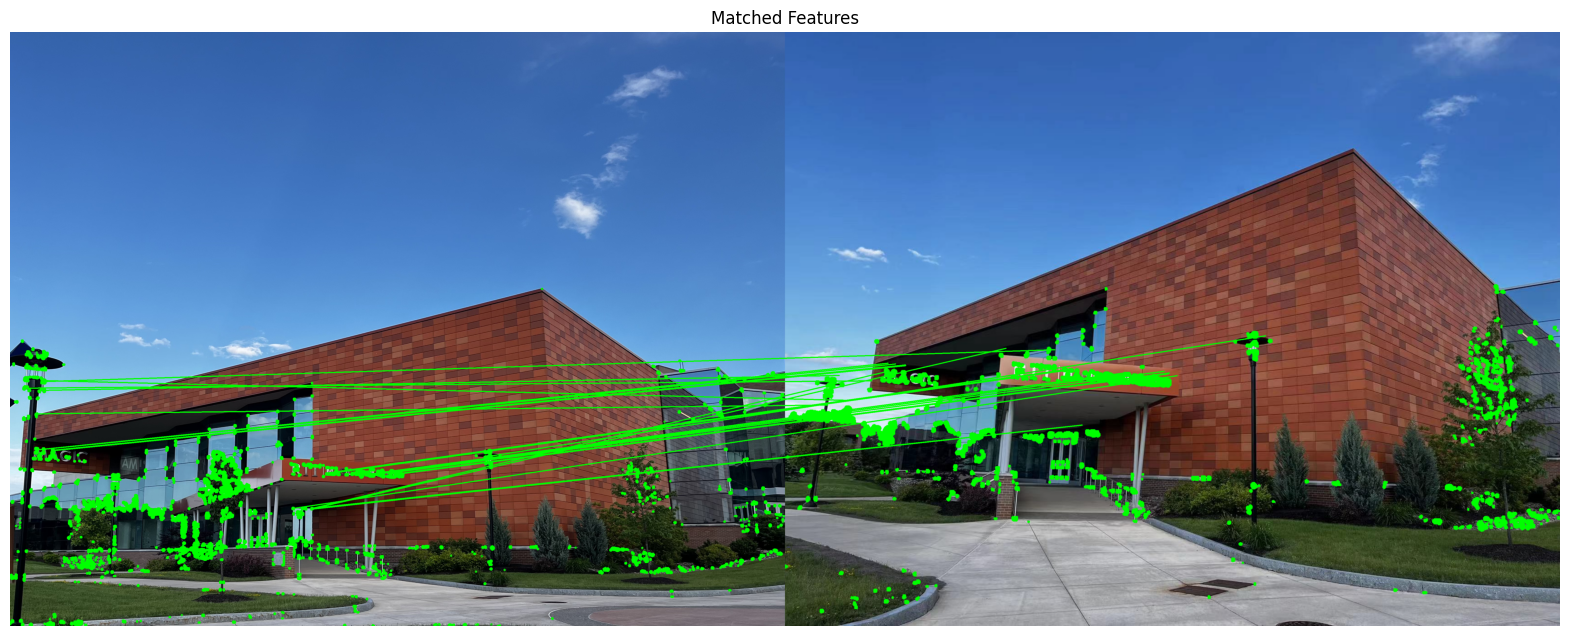

[< cv2.DMatch 00000261D4D62D30>,
 < cv2.DMatch 00000261D4CE1CB0>,
 < cv2.DMatch 00000261D1EAD510>,
 < cv2.DMatch 00000261D4CE2EF0>,
 < cv2.DMatch 00000261D4D61E90>,
 < cv2.DMatch 00000261D4D62830>,
 < cv2.DMatch 00000261D4CE2310>,
 < cv2.DMatch 00000261D4D63610>,
 < cv2.DMatch 00000261D4CE3CF0>,
 < cv2.DMatch 00000261D4D614D0>,
 < cv2.DMatch 00000261D4D621B0>,
 < cv2.DMatch 00000261D4D63930>,
 < cv2.DMatch 00000261D4D63AD0>,
 < cv2.DMatch 00000261D4D63810>,
 < cv2.DMatch 00000261D4D639F0>,
 < cv2.DMatch 00000261D4D620B0>,
 < cv2.DMatch 00000261D4CE2A10>,
 < cv2.DMatch 00000261D4CE3D50>,
 < cv2.DMatch 00000261D4D61110>,
 < cv2.DMatch 00000261D4D609D0>,
 < cv2.DMatch 00000261D4D63450>,
 < cv2.DMatch 00000261D4C847D0>,
 < cv2.DMatch 00000261D4D60FF0>,
 < cv2.DMatch 00000261D4D633D0>]

In [59]:
best_match = None
best_match_score = float('-inf')
best_img_num = 0
for index, ref_feature in enumerate(ref_features):
    # Match features between the target and reference image
    matches = target.match_features(ref_feature)

    # Calculate a score based on the number of matches
    match_score = len(matches)

    # Update the best match if the current score is better
    if match_score > best_match_score:
        best_match = ref_feature
        best_match_score = match_score
        best_img_num = index

# Display the best match
print(f"Reference {best_img_num} is the best match")
target.match_features(best_match, display=True)